In [ ]:
#import all of basic lib
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
from tensorflow.keras import backend

In [ ]:
 #unzip and load dataset, once
"""from zipfile import ZipFile

with ZipFile(
    '/content/drive/MyDrive/Malaria-dataset/dataset-malaria-gr.zip',
    'r'
) as zip:
  zip.extractall('/content/drive/MyDrive/Malaria-dataset')"""

"from zipfile import ZipFile\n\nwith ZipFile(\n   '/content/drive/MyDrive/Malaria-dataset/dataset-malaria-gr.zip',\n   'r'\n) as zip:\n zip.extractall('/content/drive/MyDrive/Malaria-dataset')"

In [ ]:
#check all dispo dir
os.listdir('/content/drive/MyDrive/Malaria-dataset')

['Parasitized',
 'Uninfected',
 'dataset-malaria-gr.zip',
 'model_malaria_version_1_00.h5',
 'my_model.h5',
 'model_plot.png']

In [ ]:
#check Parasitized data image in index 0
print(os.listdir('/content/drive/MyDrive/Malaria-dataset/Parasitized')[0])

C68P29N_ThinF_IMG_20150819_133447_cell_130.png


In [ ]:
#check Uninfected data image in index 10 and its len
print(os.listdir('/content/drive/MyDrive/Malaria-dataset/Uninfected')[10])

C62P23N_ThinF_IMG_20150818_132918_cell_146.png


In [ ]:
#source of grouped data image
parasitezedData = os.listdir('/content/drive/MyDrive/Malaria-dataset/Parasitized')
unParasitezedData = os.listdir('/content/drive/MyDrive/Malaria-dataset/Uninfected')

In [ ]:
#function to get image length inside a directory :
def count_image_files(directory):
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
    image_count = 0

    for filename in os.listdir(directory):
        if any(filename.lower().endswith(ext) for ext in image_extensions):
            image_count += 1

    return image_count



In [ ]:
#get length of parasitized image
length_parasitized = count_image_files('/content/drive/MyDrive/Malaria-dataset/Parasitized')
length_parasitized

13779

In [ ]:
#get length of uninfected image
length_Uninfected = count_image_files('/content/drive/MyDrive/Malaria-dataset/Uninfected')
length_Uninfected

13779

In [ ]:
#total images
total_image = length_parasitized + length_Uninfected
total_image

27558

In [ ]:
#Combine all the images in one variable and simultaneously resize all image to  50, 50
# Data preprocessing.
dataArrayImage = []
labels = []

for i in parasitezedData:
    try:

        image = cv2.imread("/content/drive/MyDrive/Malaria-dataset/Parasitized/"+i)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((50 , 50))
        rotated45 = resize_img.rotate(45)
        rotated75 = resize_img.rotate(75)
        blur = cv2.blur(np.array(resize_img) ,(10,10))
        dataArrayImage.append(np.array(resize_img))
        dataArrayImage.append(np.array(rotated45))
        dataArrayImage.append(np.array(rotated75))
        dataArrayImage.append(np.array(blur))
        labels.append(1)
        labels.append(1)
        labels.append(1)
        labels.append(1)

    except AttributeError:
        print('')

for u in unParasitezedData:
    try:

        image = cv2.imread("/content/drive/MyDrive/Malaria-dataset/Uninfected/"+u)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((50 , 50))
        rotated45 = resize_img.rotate(45)
        rotated75 = resize_img.rotate(75)
        dataArrayImage.append(np.array(resize_img))
        dataArrayImage.append(np.array(rotated45))
        dataArrayImage.append(np.array(rotated75))
        labels.append(0)
        labels.append(0)
        labels.append(0)

    except AttributeError:
        print('')

In [ ]:
#data augmentation
cells = np.array(dataArrayImage)
labels = np.array(labels)

np.save('Cells' , cells)
np.save('Labels' , labels)

In [ ]:
print('Cells : {} | labels : {}'.format(cells.shape , labels.shape))

Cells : (96453, 50, 50, 3) | labels : (96453,)


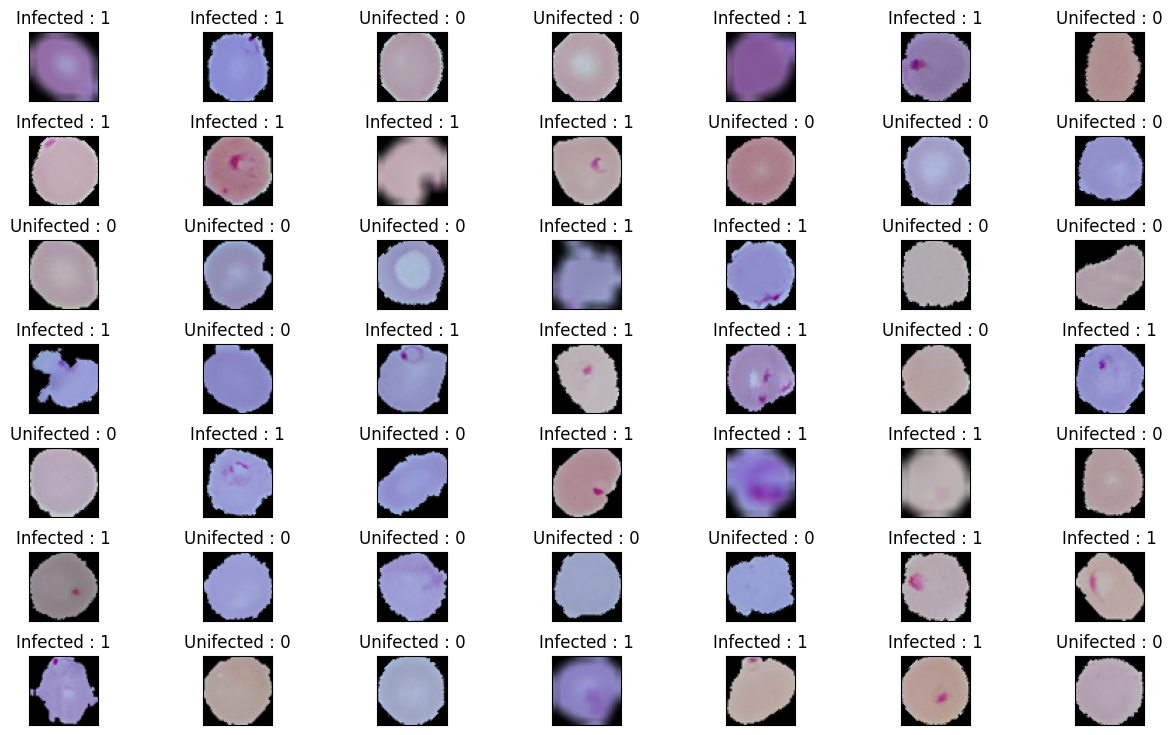

In [ ]:
plt.figure(1 , figsize = (15 , 9))
n = 0
for i in range(49):
    n += 1
    r = np.random.randint(0 , cells.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(cells[r[0]])
    plt.title('{} : {}'.format('Infected' if labels[r[0]] == 1 else 'Unifected' ,
                               labels[r[0]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()

In [ ]:
# load array as np array for all task
imageData = np.array(dataArrayImage)
labels = np.array(labels)
#test
print("imageData:",len(imageData))
print("labels:",len(labels))


imageData: 96453
labels: 96453


3 Parasitized :



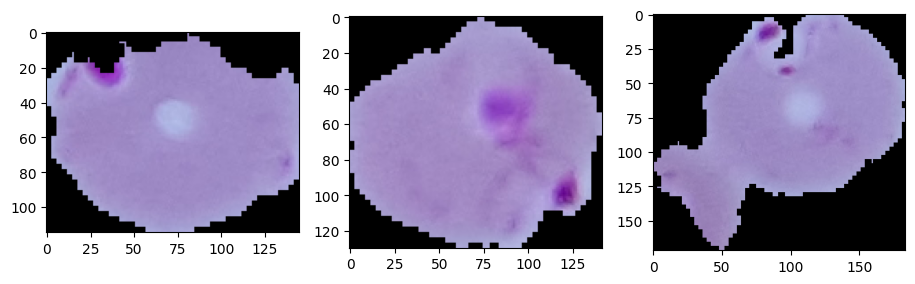

3 Uninfected:



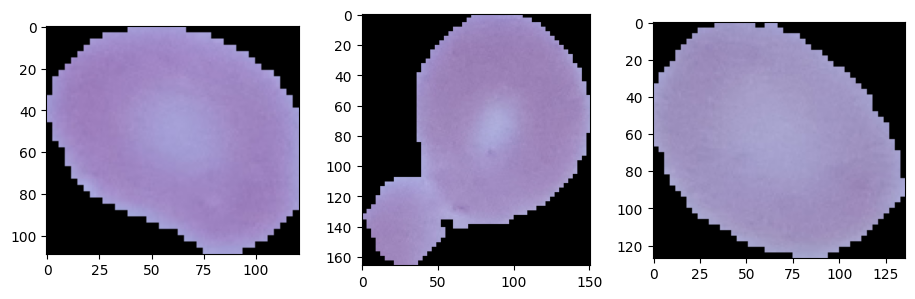

In [ ]:
#data viz
print("3 Parasitized :\n")
plt.figure(figsize = (15,15))
for i in range(3):
    plt.subplot(4, 4, i+1)
    img = cv2.imread('/content/drive/MyDrive/Malaria-dataset/Parasitized/'+ parasitezedData[i])
    plt.imshow(img)
plt.show()

print("3 Uninfected:\n")
plt.figure(figsize = (15,15))
for i in range(3):
    plt.subplot(4, 4, i+1)
    img = cv2.imread('/content/drive/MyDrive/Malaria-dataset/Uninfected/'+ unParasitezedData[i])
    plt.imshow(img)
plt.show()

In [ ]:
#prepa train and test
from sklearn.model_selection import train_test_split

# Définir la taille de la partition de validation
validation_size = 0.1

# Fractionner les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(imageData, labels, test_size = (validation_size + 0.2), random_state = 0)

# Fractionner l'ensemble de test en ensembles de test et de validation
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = (validation_size / (validation_size + 0.2)), random_state = 0)

# Convertir les labels en format catégorique
y_train = utils.to_categorical(y_train, num_classes = 2)
y_test = utils.to_categorical(y_test, num_classes = 2)
y_val = utils.to_categorical(y_val, num_classes = 2)

# Afficher les tailles des ensembles de données
print("X_train:", len(X_train))
print("X_test:", len(X_test))
print("X_val:", len(X_val))
print("y_train:", len(y_train))
print("y_test:", len(y_test))
print("y_val:", len(y_val))


X_train: 67517
X_test: 19290
X_val: 9646
y_train: 67517
y_test: 19290
y_val: 9646


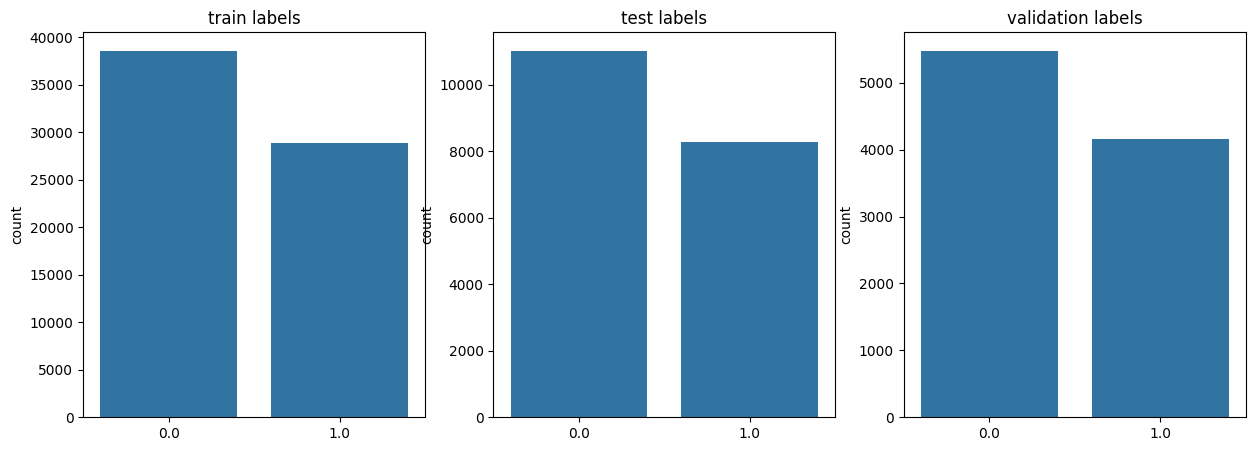

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(1, figsize=(15, 5))
n = 0
for label_data, label in zip([y_train, y_test, y_val], ['train labels', 'test labels', 'validation labels']):
    n += 1
    plt.subplot(1, 3, n)
    sns.countplot(x=label_data[:, 0])
    plt.title(label)
plt.show()

In [ ]:
#Use the CNN model

model = Sequential()

inputShape = (50, 50, 3)

if backend.image_data_format() == 'channels_first':
    inputShape = (3, 50, 50)

model.add(Conv2D(32, (3,3), activation='relu', input_shape=inputShape))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 24, 24, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 64)        0

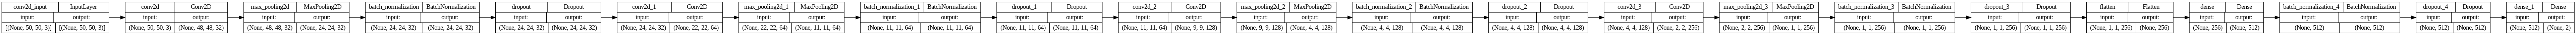

In [ ]:
from tensorflow.keras.utils import plot_model

# Visualisation du modèle avec plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir='LR', expand_nested=True)

In [ ]:
#Compilation
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
# Set up logging for predictions
import tensorflow as tf
tensors_to_log = {'probabilities': 'softmax_tensor'}
logging_hook = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)

In [ ]:
#model fitting
model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
2110/2110 [==============================] - 358s 168ms/step - loss: 0.2728 - accuracy: 0.8942
Epoch 2/30
2110/2110 [==============================] - 362s 172ms/step - loss: 0.1577 - accuracy: 0.9468
Epoch 3/30
2110/2110 [==============================] - 362s 171ms/step - loss: 0.1457 - accuracy: 0.9508
Epoch 4/30
2110/2110 [==============================] - 356s 169ms/step - loss: 0.1393 - accuracy: 0.9533
Epoch 5/30
2110/2110 [==============================] - 363s 172ms/step - loss: 0.1331 - accuracy: 0.9547
Epoch 6/30
2110/2110 [==============================] - 394s 187ms/step - loss: 0.1271 - accuracy: 0.9579
Epoch 7/30
2110/2110 [==============================] - 360s 171ms/step - loss: 0.1223 - accuracy: 0.9589
Epoch 8/30
2110/2110 [==============================] - 354s 168ms/step - loss: 0.1162 - accuracy: 0.9604
Epoch 9/30
2110/2110 [==============================] - 357s 169ms/step - loss: 0.1133 - accuracy: 0.9616
Epoch 10/30
2110/2110 [=======================

In [ ]:
model.save('my_model1.h5')  # Save the model after initial training

In [ ]:
#on import le modèle my_model5
'''from tensorflow.keras.models import load_model
model = load_model('my_model1.h5')
history = model.fit(X_train, y_train, epochs = 5, batch_size = 32)'''

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 24, 24, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 64)        0

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 24, 24, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 64)        0

In [ ]:
#evaluation de l'ensemble de test en calculant la perte et la précision
predict = model.evaluate(X_test, y_test)
print("Loss: ",predict[0])
print("Accuracy: ",predict[1]*100)

603/603 [==============================] - 25s 42ms/step - loss: 0.0922 - accuracy: 0.9670
Loss:  0.09223382920026779
Accuracy:  96.70295715332031


In [ ]:
#Matrice de confusion
from sklearn.metrics import confusion_matrix

In [ ]:
#Prédire les classes sur l'ensemble de test
y_pred = model.predict(X_test)

603/603 [==============================] - 26s 42ms/step


In [ ]:
# Convertir les prédictions en classes:
y_pred_classes = np.argmax(y_pred, axis=1)

In [ ]:
print("y_train type:", type(y_train))
print("y_test type:", type(y_test))
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train type: <class 'numpy.ndarray'>
y_test type: <class 'numpy.ndarray'>
y_train shape: (67517, 2)
y_test shape: (19290, 2)


In [ ]:
#Création de la matrice de confusion:
y_test_binary = np.argmax(y_test, axis=1)
confusion_mat = confusion_matrix(y_test_binary, y_pred_classes)
confusion_mat

array([[ 8015,   249],
       [  387, 10639]])

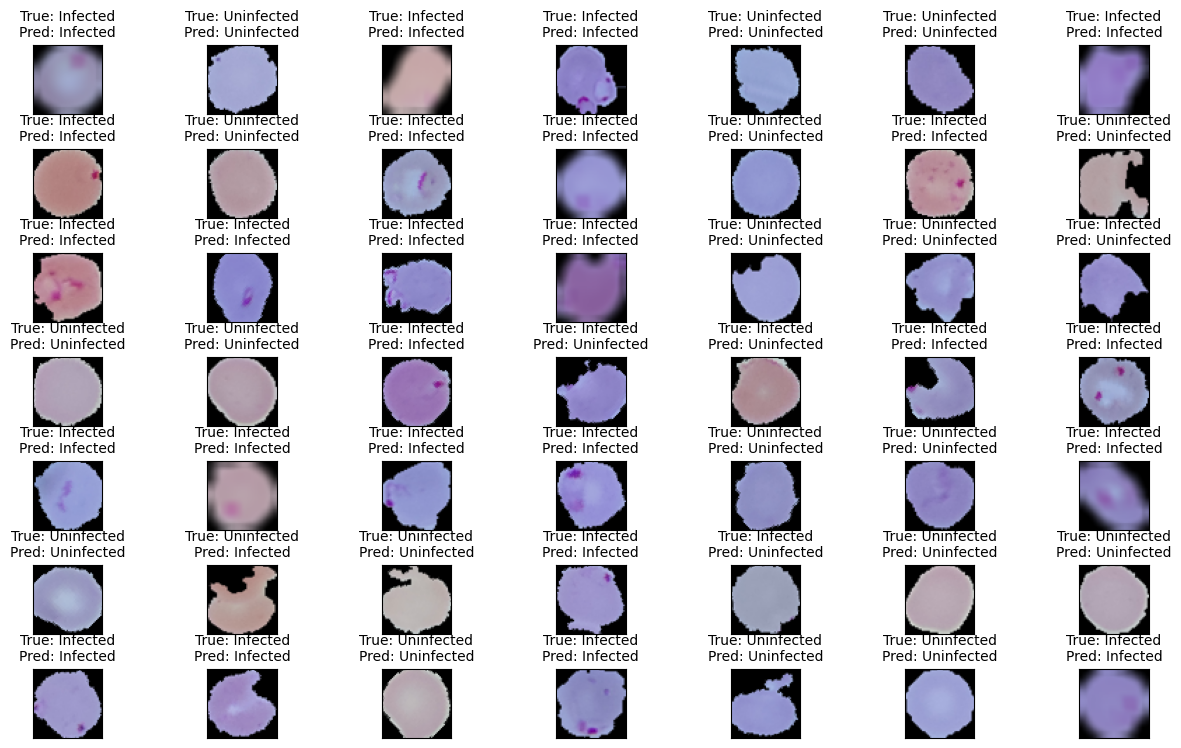

In [ ]:
plt.figure(1, figsize=(15, 9))
n = 0

# Assuming one-hot encoded labels
classes = ["Uninfected", "Infected"]  # Define class names for readability

for i in range(49):
    n += 1
    r = np.random.randint(0, X_test.shape[0], 1)

    # Check if subplot position is within grid capacity
    if n <= 49:
        plt.subplot(7, 7, n)
        plt.subplots_adjust(hspace=0.5, wspace=0.5)

        # Get true and predicted labels from y_test and y_pred
        true_label_index = np.argmax(y_test[r[0]])  # Convert one-hot encoded label to index
        predicted_label_index = np.argmax(y_pred[r[0]])
        true_label = classes[true_label_index]
        predicted_label = classes[predicted_label_index]

        plt.imshow(X_test[r[0]])
        plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=10)  # Clear title with labels
        plt.xticks([]), plt.yticks([])

plt.show()

In [ ]:
#Saving model
%cd "/content/drive/MyDrive/Malaria-dataset"
model.save('model_malaria_version_2_00.h5')
from tensorflow.keras.models import load_model
model = load_model('model_malaria_version_2_00.h5')
model.summary()

/content/drive/MyDrive/Malaria-dataset
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 24, 24, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 

In [ ]:
#evaluation de l'ensemble de test en calculant la perte et la précision
predict = model.evaluate(X_test, y_test)
print("Loss: ",predict[0])
print("Accuracy: ",predict[1]*100)

603/603 [==============================] - 24s 40ms/step - loss: 0.1108 - accuracy: 0.9614
Loss:  0.11076704412698746
Accuracy:  96.13789319992065


**EfficientNet :**
EfficientNet est une architecture de CNN introduite en 2019 qui vise à optimiser les performances en termes de précision et d'efficacité computationnelle. Elle utilise une approche d'équilibrage des dimensions de réseau en modifiant simultanément la largeur, la profondeur et la résolution des modèles. Les modèles EfficientNet sont conçus pour être plus performants que d'autres architectures avec une taille de modèle similaire.
On va combiner ce type de CNN avec notre modèle

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


Correction de chargement de données de test, eval et train

In [ ]:
# Définir la taille de la partition de validation
validation_size = 0.1

# Fractionner les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(imageData, labels, test_size = (validation_size + 0.2), random_state = 0)

# Fractionner l'ensemble de test en ensembles de test et de validation
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = (validation_size / (validation_size + 0.2)), random_state = 0)

# Convertir les labels en format catégorique
y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)
y_val = to_categorical(y_val, num_classes = 2)

# Afficher les tailles des ensembles de données
print("X_train:", len(X_train))
print("X_test:", len(X_test))
print("X_val:", len(X_val))
print("y_train:", len(y_train))
print("y_test:", len(y_test))
print("y_val:", len(y_val))


X_train: 67517
X_test: 19290
X_val: 9646
y_train: 67517
y_test: 19290
y_val: 9646


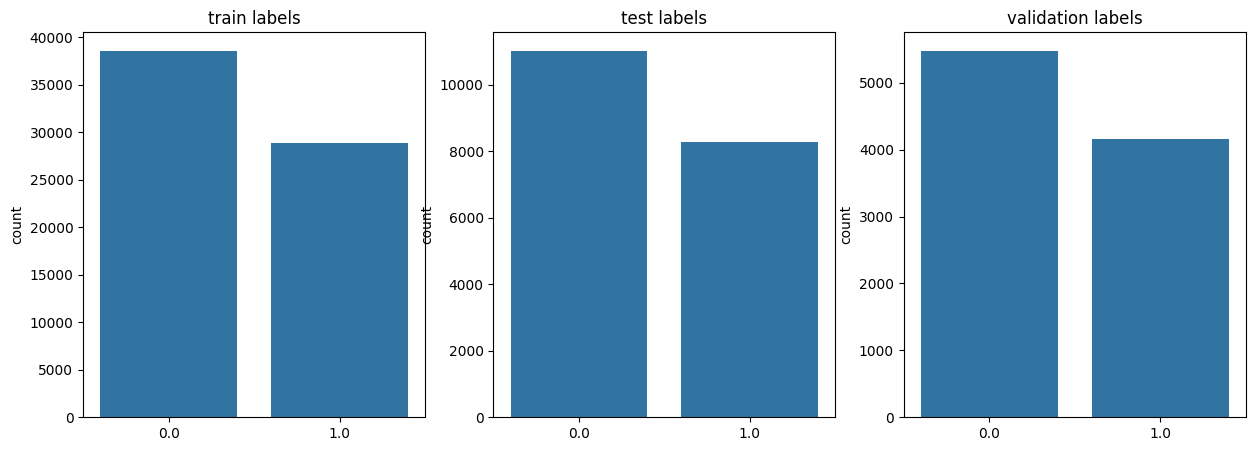

In [ ]:

plt.figure(1, figsize=(15, 5))
n = 0
for label_data, label in zip([y_train, y_test, y_val], ['train labels', 'test labels', 'validation labels']):
    n += 1
    plt.subplot(1, 3, n)
    sns.countplot(x=label_data[:, 0])
    plt.title(label)
plt.show()

In [ ]:
# Convertir les labels en format catégorique
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

Modèle EfficientNetB0:

In [ ]:
# Chargement du modèle EfficientNetB0 sans les couches supérieures
base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Ajout des nouvelles couches au modèle EfficientNet
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# Création du modèle final
model_efficientnet = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Geler les poids de toutes les couches de base_model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compilation du modèle
model_efficientnet.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Nouvelle section